In [15]:
import collections
import random

# # Data Style
# graph_data = {
#     '2': ['6'],
#     '6': ['2', '5', '7', '12'],
#     '3': ['4', '9'],
#     #...
# }

def verify_coverage(raw_data, final_sets):
    """
    Verifies that every connection in 'raw_data' appears at least once 
    in 'final_sets'.
    
    Returns:
        missing_edges (list): A list of edges that were NEVER tested.
        coverage_stats (dict): Stats on how well the graph is covered.
    """
    # 1. Reconstruct the Truth (All expected unique edges)
    expected_edges = set()
    for u, neighbors in raw_data.items():
        for v in neighbors:
            # Normalize edge to (min, max) to handle undirected nature
            u_int, v_int = int(u), int(v)
            p1, p2 = min(u_int, v_int), max(u_int, v_int)
            expected_edges.add((str(p1), str(p2)))
            
    # 2. Flatten the generated circuits into a single set of tested edges
    tested_edges = set()
    total_tests = 0
    for s in final_sets:
        for u, v in s:
            u_int, v_int = int(u), int(v)
            p1, p2 = min(u_int, v_int), max(u_int, v_int)
            tested_edges.add((str(p1), str(p2)))
            total_tests += 1

    # 3. Find Diff
    missing_edges = list(expected_edges - tested_edges)
    
    # 4. Reporting
    circuit_count = len(final_sets)
    total_expected = len(expected_edges)
    unique_tested = len(tested_edges)
    coverage_percent = (unique_tested / total_expected) * 100 if total_expected > 0 else 0.0
    
    print("-" * 40)
    print(f"VERIFICATION REPORT")
    print("-" * 40)
    print(f"Total Number of Circuits:    {circuit_count}")
    print(f"Total Unique Edges in Graph: {total_expected}")
    print(f"Unique Edges Tested:         {unique_tested}")
    print(f"Total Tests Performed:       {total_tests} (Avg {total_tests/total_expected:.2f}x redundancy)" if total_expected else "N/A")
    print(f"Coverage:                    {coverage_percent:.1f}%")
    
    if missing_edges:
        print(f"\n[FAIL] {len(missing_edges)} edges are MISSING:")
        for edge in missing_edges:
            print(f"  - Edge {edge}")
    else:
        print("\n[PASS] All connections tested at least once.")
    print("-" * 40)

    return missing_edges

def compact_sets(sets):
    """
    Post-processing to maximize density in earlier sets.
    Tries to move edges from Set 5 -> Set 1, Set 4 -> Set 2, etc.
    """
    # Flatten sets into a list of mutable sets
    layers = [set(s) for s in sets]
    num_layers = len(layers)

    changed = True
    while changed:
        changed = False
        # Iterate backwards: Try to empty the last set into the first set
        for i in range(num_layers - 1, 0, -1):      # Source Layer (e.g., 4)
            for j in range(i):                       # Target Layer (e.g., 0, 1, 2, 3)
                
                # Identify candidates to move from Layer i to Layer j
                # An edge (u, v) can move to Layer j if neither u nor v are busy in Layer j
                
                # Build 'busy' map for target layer j for fast lookup
                busy_nodes = {n for pair in layers[j] for n in pair}
                
                # Find moveable edges
                movable = []
                for u, v in layers[i]:
                    if u not in busy_nodes and v not in busy_nodes:
                        movable.append((u, v))
                        # Update busy_nodes temporarily so we don't move conflicting edges at once
                        busy_nodes.add(u)
                        busy_nodes.add(v)
                
                # Perform moves
                if movable:
                    for edge in movable:
                        layers[i].remove(edge)
                        layers[j].add(edge)
                    changed = True

    # Remove empty sets from the end (if any were fully emptied)
    return [s for s in layers if s]

def fill_with_redundancy(all_edges, current_sets):
        """
        Fills empty slots in existing sets with redundant edges.
        PRIORITY: Edges that have been tested the least so far.
        """
        # 1. Global Counter: How many times has each edge been tested?
        edge_counts = collections.defaultdict(int)
        for s in current_sets:
            for edge in s:
                edge_counts[edge] += 1
        
        # Ensure all edges are in the counter (even if count is 0, though it shouldn't be)
        for edge in all_edges:
            if edge not in edge_counts:
                edge_counts[edge] = 0

        # 2. Iterate through each set to fill 'holes'
        for s in current_sets:
            # Identify which qubits are currently busy in this circuit
            busy_nodes = {n for u, v in s for n in (u, v)}
            
            # Find all valid candidates for this specific circuit
            candidates = []
            for u, v in all_edges:
                # Rule 1: Edge must not already be in this specific circuit
                if (u, v) in s:
                    continue
                
                # Rule 2: Both Qubits must be free in this circuit
                if u not in busy_nodes and v not in busy_nodes:
                    candidates.append((u, v))
            
            # 3. Smart Sort: "Least Tested First"
            # We shuffle first to break ties randomly (ensuring uniform distribution)
            random.shuffle(candidates)
            candidates.sort(key=lambda e: edge_counts[e])
            
            # 4. Greedy Fill
            for u, v in candidates:
                # Re-check availability (since a previous candidate might have taken the spot)
                if u not in busy_nodes and v not in busy_nodes:
                    s.add((u, v))
                    
                    # Mark nodes as busy for this circuit
                    busy_nodes.add(u)
                    busy_nodes.add(v)
                    
                    # Increment global count so next circuits favor other edges
                    edge_counts[(u, v)] += 1
                    
        return current_sets


class MisraGriesSolver:
    def __init__(self, raw_data, max_sets=5):
        self.adj = collections.defaultdict(dict)  # self.adj[u][v] = colour
        self.all_edges = []
        self.max_sets = max_sets
        
        # --- Pre-processing ---
        seen = set()
        for u, neighbors in raw_data.items():
            for v in neighbors:
                u_int, v_int = int(u), int(v)
                p1, p2 = min(u_int, v_int), max(u_int, v_int)
                
                # Store edge
                if (p1, p2) not in seen:
                    self.all_edges.append((str(p1), str(p2)))
                    seen.add((p1, p2))
                
                # Initialize adj structure
                if str(v) not in self.adj[str(p1)]: self.adj[str(p1)][str(v)] = None
                if str(p1) not in self.adj[str(v)]: self.adj[str(v)][str(p1)] = None

    def get_free_colours(self, u, max_colours):
        """Returns a set of colours NOT used by node u."""
        used = {self.adj[u][n] for n in self.adj[u] if self.adj[u][n] is not None}
        return {c for c in range(1, max_colours + 1) if c not in used}

    def invert_path(self, u, v, c_u, c_v):
        """Inverts a 2-coloured path (Kempe Chain) starting at u."""
        path = []
        curr = u
        seeking = c_u
        other = c_v
        
        # Build path
        while True:
            found_next = False
            for neighbor, colour in self.adj[curr].items():
                if colour == seeking and neighbor != v: # Don't go back to v immediately
                    # prevent cycles or immediate backtracking logic if needed, 
                    # but simple traversal usually works for Kempe
                    if (curr, neighbor) not in path and (neighbor, curr) not in path:
                        path.append((curr, neighbor))
                        curr = neighbor
                        seeking, other = other, seeking
                        found_next = True
                        break
            if not found_next:
                break
        
        # Swap colours
        for n1, n2 in path:
            current_c = self.adj[n1][n2]
            new_c = c_v if current_c == c_u else c_u
            self.adj[n1][n2] = new_c
            self.adj[n2][n1] = new_c

    def solve(self):
        max_degree = 0
        for u in self.adj:
            max_degree = max(max_degree, len(self.adj[u]) - 1)  # Degree is number of edges

        if max_degree > self.max_sets:
            raise ValueError("Graph degree exceeds maximum allowed sets.")
        elif max_degree != self.max_sets:
            print(f"Warning: Graph degree ({max_degree}) is less than max sets ({self.max_sets}). Using a maximum of {max_degree + 1} sets instead.")

        # Vizing's theorem guarantees solution with Delta + 1 colours
        max_colours = max_degree + 1
        print(f"Graph Degree: {max_degree}. Solving with max {max_colours} circuits.")

        for x, y in self.all_edges:
            # 1. Find free colours for u (x) and v (y)
            free_x = list(self.get_free_colours(x, max_colours))
            free_y = list(self.get_free_colours(y, max_colours))
            
            # Case 1: Easy match
            common = set(free_x).intersection(free_y)
            if common:
                c = list(common)[0]
                self.adj[x][y] = c
                self.adj[y][x] = c
                continue

            # Case 2: The Fan Argument (Misra & Gries)
            # If no common colour, we must swap.
            # For simplicity in this implementation, we use the standard "Kempe Swap" 
            # which is the subroutine inside Vizing's proof.
            
            c_x = free_x[0]
            c_y = free_y[0]
            
            # Try to swap colours on the path starting from y using colours (c_x, c_y)
            # This frees up c_x at node y
            self.invert_path(y, x, c_x, c_y)
            
            # Now assign c_x to the edge (x, y)
            self.adj[x][y] = c_x
            self.adj[y][x] = c_x

        # Extract Sets
        sets = [set() for _ in range(max_colours)]
        for u, neighbors in self.adj.items():
            for v, colour in neighbors.items():
                if int(u) < int(v) and colour is not None:
                    sets[colour-1].add((u, v))
        
        # Filter out empty sets (if graph was actually Class 1)
        return [s for s in sets if s]
    

def generate_circuits(raw_data, solver_class = MisraGriesSolver, max_sets=5, compaction=True, redundancy=True):
        """
        Parameters:
        - solver_class: A class reference to the solver to use (Only MisraGriesSolver for now...).
        - raw_data: The raw graph data in adjacency list format.
        - max_sets: Maximum number of sets (circuits) to use.

        Generates an optimal schedule using the specified solver class.
        Steps:
        1. Solve: Use the provided solver to get initial sets.
        2. Compact: Rearrange sets to maximize early density.
        3. Redundancy: Fill in gaps with least-tested edges.
        4. Return final sets.

        Returns:
        final_sets: A list of sets representing the optimal schedule.
        """
        # Solver: 
        solver = solver_class(raw_data, max_sets)
        sets = solver.solve() 
        
        # Compaction: (Efficiency)
        if compaction:
            sets = compact_sets(sets)
        
        # Redundancy: Fill the circuit gaps with extra tests (Statistics)
        if redundancy:
            sets = fill_with_redundancy(solver.all_edges, sets)
        
        missing = verify_coverage(raw_data, sets)

        if missing:
            raise RuntimeError(f'Critical: The solver failed to cover the full graph!\n{missing} are not covered.')

        return sets, solver


Initializing solver...
Graph Degree: 4. Solving with max 5 circuits.
----------------------------------------
VERIFICATION REPORT
----------------------------------------
Total Number of Circuits:    4
Total Unique Edges in Graph: 82
Unique Edges Tested:         82
Total Tests Performed:       92 (Avg 1.12x redundancy)
Coverage:                    100.0%

[PASS] All connections tested at least once.
----------------------------------------

DONE in 0.0019 seconds.
Total Edges in Graph: 82
------------------------------
Efficiency: 0.9259259259259259


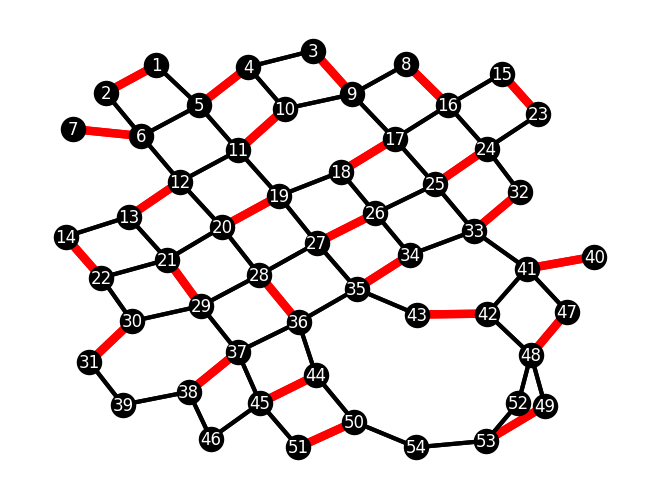

Efficiency: 0.8518518518518519


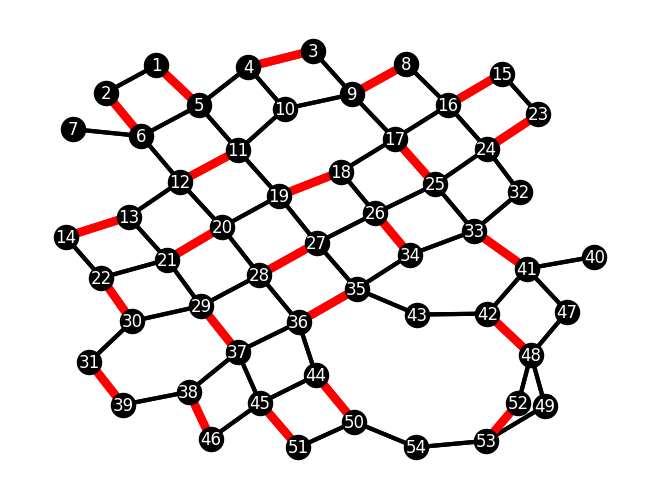

Efficiency: 0.7777777777777778


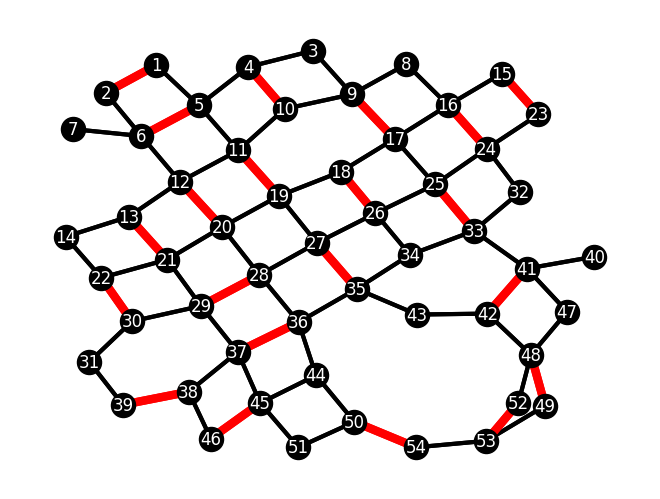

Efficiency: 0.8518518518518519


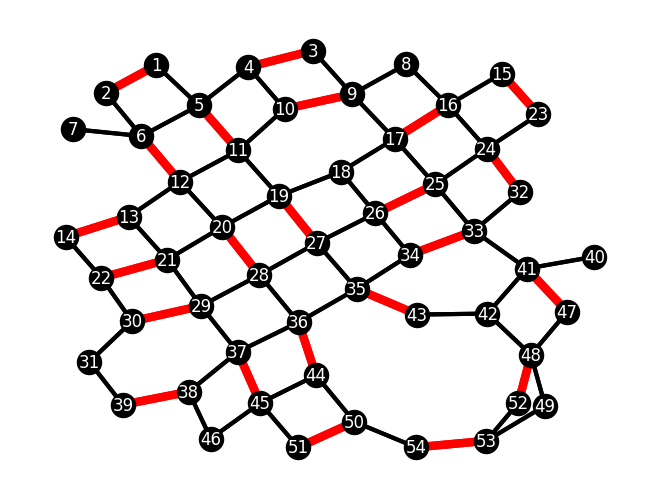

In [16]:
import networkx as nx
from braket.aws import AwsDevice
from braket.circuits import Circuit
from braket.devices import Devices
import time
import matplotlib.pyplot as plt
%matplotlib inline

# Ankaa_device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-3")
Emerald_device = AwsDevice("arn:aws:braket:eu-north-1::device/qpu/iqm/Emerald")

G = Emerald_device.topology_graph

start_time = time.time()
print("Initializing solver...")
total_connectivity = Emerald_device.properties.paradigm.connectivity.connectivityGraph
qubits = [qub for qub in total_connectivity]
qubits.sort(key=float)

# solver = ExactGraphSolver(total_connectivity, max_sets=4)
# initial_sets = solver.solve()
final_sets, solver = generate_circuits(total_connectivity, max_sets=4, compaction = True, redundancy = True)

end_time = time.time()

print(f"\nDONE in {end_time - start_time:.4f} seconds.")
print(f"Total Edges in Graph: {len(solver.all_edges)}")
print("-" * 30)

# for i, s in enumerate(final_sets):
#     # Sort for readable output
#     sorted_s = sorted(list(s), key=lambda x: int(x[0]))
#     # print(f"Set {i+1} ({len(s)} pairs): {sorted_s}")
    
#     # Verification
#     nodes = [n for p in s for n in p]
#     if len(nodes) != len(set(nodes)):
#         print("  ERROR: Duplicate node detected!")


for i in range(len(final_sets)):
    
    red_edges = list(final_sets[i])
    connected_qubits = [str(qub_pair[0]) for qub_pair in red_edges] + [str(qub_pair[1]) for qub_pair in red_edges]
    connected_qubits.sort(key=float)
    # print("Connected Qubits:\n",connected_qubits,"\n")
    # print("Total Qubits:\n",qubits,"\n")
    print("Efficiency:", len(connected_qubits)/len(qubits))
    
    # 3. Create a color map based on G.edges()
    edge_colors = []
    widths = []
    for u, v in G.edges():
        u = str(u)
        v = str(v)
        # Check if the edge (or its reverse) is in your red_subset
        if (u, v) in red_edges or (v, u) in red_edges:
            edge_colors.append('red')
            widths.append(6)
        else:
            edge_colors.append('black')
            widths.append(3)
    
    black_edges = [e for e in G.edges() if e not in red_edges and (e[1], e[0]) not in red_edges]

    nx.draw_kamada_kawai(G, with_labels=True, edge_color=edge_colors, node_color = 'black' ,font_color="white", width = widths, arrows=False)
    plt.show()



In [17]:
final_sets[3]

{('1', '2'),
 ('13', '14'),
 ('15', '23'),
 ('16', '17'),
 ('19', '27'),
 ('20', '28'),
 ('21', '22'),
 ('24', '32'),
 ('25', '26'),
 ('29', '30'),
 ('3', '4'),
 ('33', '34'),
 ('35', '43'),
 ('36', '44'),
 ('37', '45'),
 ('38', '39'),
 ('41', '47'),
 ('48', '52'),
 ('5', '11'),
 ('50', '51'),
 ('53', '54'),
 ('6', '12'),
 ('9', '10')}